In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpbum63no5/pubring.gpg' created
gpg: /tmp/tmpbum63no5/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [0]:
import os
!mkdir -p drive
!google-drive-ocamlfuse drive
os.chdir('drive/UCL/Project/Brett-Chan/Autoencoders/Beta-VAE/disentangled_vae-master')
os.getcwd()

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


'/content/drive/UCL/Project/Brett-Chan/Autoencoders/Beta-VAE/disentangled_vae-master'

In [0]:
# -*- coding: utf-8 -*-
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import random
import os
from scipy.misc import imsave

from model import VAE
from data_manager import DataManager

import matplotlib.pyplot as plt

tf.app.flags.DEFINE_integer("epoch_size", 2000, "epoch size")
tf.app.flags.DEFINE_integer("batch_size", 64, "batch size")
tf.app.flags.DEFINE_float("gamma", 100.0, "gamma param for latent loss")
tf.app.flags.DEFINE_float("capacity_limit", 20.0,
                          "encoding capacity limit param for latent loss")
tf.app.flags.DEFINE_integer("capacity_change_duration", 100000,
                            "encoding capacity change duration")
tf.app.flags.DEFINE_float("learning_rate", 5e-4, "learning rate")
tf.app.flags.DEFINE_string("checkpoint_dir", "checkpoints", "checkpoint directory")
tf.app.flags.DEFINE_string("log_file", "./log", "log file directory")
tf.app.flags.DEFINE_boolean("training", True, "training or not")

flags = tf.app.flags.FLAGS

In [0]:
def train(sess,
          model,
          manager,
          saver):

  summary_writer = tf.summary.FileWriter(flags.log_file, sess.graph)
  
  n_samples = manager.sample_size

  reconstruct_check_images = manager.get_random_images(10)

  indices = list(range(n_samples))

  step = 0
  var = []
  
  # Training cycle
  for epoch in range(flags.epoch_size):
    # Shuffle image indices
    random.shuffle(indices)
    
    avg_cost = 0.0
    total_batch = n_samples // flags.batch_size
    
    # Loop over all batches
    for i in range(total_batch):
      # Generate image batch
      batch_indices = indices[flags.batch_size*i : flags.batch_size*(i+1)]
      batch_xs = manager.get_images(batch_indices)
      
      # Fit training using batch data
      reconstr_loss, latent_loss, summary_str = model.partial_fit(sess, batch_xs, step)
      summary_writer.add_summary(summary_str, step)
      step += 1
      
      if i%1000==0:
        print("epoch: "+str(epoch)+" step: "+str(i)+"/"+str(total_batch), reconstr_loss, latent_loss)
        reconstruct_check_temp(sess, model, reconstruct_check_images)
        var = disentangle_check_temp(sess, model, manager, var)
        
#     # Image reconstruction check
#     reconstruct_check(sess, model, reconstruct_check_images)

#     # Disentangle check
#     disentangle_check(sess, model, manager)

#     # Save checkpoint
#     saver.save(sess, flags.checkpoint_dir + '/' + 'checkpoint', global_step = step)

    
def reconstruct_check_temp(sess, model, images):
  # Check image reconstruction
  x_reconstruct = model.reconstruct(sess, images)

  for i in range(len(images)):
    org_img = images[i].reshape(64, 64)
    org_img = org_img.astype(np.float32)
    reconstr_img = x_reconstruct[i].reshape(64, 64)
    
    if i==0:
      plt.figure(facecolor='grey')
      plt.subplot(121)
      plt.title("org_img")
      plt.imshow(org_img)
      plt.axis('off')

      plt.subplot(122)
      plt.title("reconstr_img")
      plt.imshow(reconstr_img)
      plt.axis('off')
      plt.show()

def reconstruct_check(sess, model, images):
  # Check image reconstruction
  x_reconstruct = model.reconstruct(sess, images)

  if not os.path.exists("reconstr_img"):
    os.mkdir("reconstr_img")

  for i in range(len(images)):
    org_img = images[i].reshape(64, 64)
    org_img = org_img.astype(np.float32)
    reconstr_img = x_reconstruct[i].reshape(64, 64)    
    
    imsave("reconstr_img/org_{0}.png".format(i),      org_img)
    imsave("reconstr_img/reconstr_{0}.png".format(i), reconstr_img)


def disentangle_check_temp(sess, model, manager, var, save_original=False):
  img = manager.get_image(shape=1, scale=2, orientation=5)
  
  batch_xs = [img]
  z_mean, z_log_sigma_sq = model.transform(sess, batch_xs)
  z_sigma_sq = np.exp(z_log_sigma_sq)[0]
  
  var.append(z_sigma_sq.reshape(10,1))
  var_graph = np.concatenate(var, axis=1)

  # Save disentangled images
  z_m = z_mean[0]
  n_z = 10
  
  ind = np.argsort(np.array(var[-1]).flatten())
  ind_inv = np.argsort(ind)
  
  plt.figure(figsize=(10,10), facecolor='grey')
  for target_z_index in range(n_z):
    for ri in range(n_z):
      value = -3.0 + (6.0 / 9.0) * ri
      z_mean2 = np.zeros((1, n_z))
      for i in range(n_z):
        if( i == target_z_index ):
          z_mean2[0][i] = value
        else:
          z_mean2[0][i] = z_m[i]
      reconstr_img = model.generate(sess, z_mean2)
      rimg = reconstr_img[0].reshape(64, 64)

      plt.subplot(n_z, n_z, ind_inv[target_z_index]*n_z + ri+1)
      plt.imshow(rimg)
      plt.axis('off')
  plt.show()  
  

  
  plt.figure()
  for v in range(n_z):
    plt.plot(range(var_graph.shape[1]), var_graph[ind[v],:], label=v+1)
  plt.legend()
  plt.show()
  
  return var
  
      
    
def disentangle_check(sess, model, manager, save_original=False):
  img = manager.get_image(shape=1, scale=2, orientation=5)
  if save_original:
    imsave("original.png", img.reshape(64, 64).astype(np.float32))
    
  batch_xs = [img]
  z_mean, z_log_sigma_sq = model.transform(sess, batch_xs)
  z_sigma_sq = np.exp(z_log_sigma_sq)[0]

  # Print variance
  zss_str = ""
  for i,zss in enumerate(z_sigma_sq):
    str = "z{0}={1:.4f}".format(i,zss)
    zss_str += str + ", "
  print(zss_str)

  # Save disentangled images
  z_m = z_mean[0]
  n_z = 10

  if not os.path.exists("disentangle_img"):
    os.mkdir("disentangle_img")

  for target_z_index in range(n_z):
    for ri in range(n_z):
      value = -3.0 + (6.0 / 9.0) * ri
      z_mean2 = np.zeros((1, n_z))
      for i in range(n_z):
        if( i == target_z_index ):
          z_mean2[0][i] = value
        else:
          z_mean2[0][i] = z_m[i]
      reconstr_img = model.generate(sess, z_mean2)
      rimg = reconstr_img[0].reshape(64, 64)
      
      imsave("disentangle_img/check_z{0}_{1}.png".format(target_z_index,ri), rimg)
      

def load_checkpoints(sess):
  saver = tf.train.Saver()
  checkpoint = tf.train.get_checkpoint_state(flags.checkpoint_dir)
  if checkpoint and checkpoint.model_checkpoint_path:
    saver.restore(sess, checkpoint.model_checkpoint_path)
    print("loaded checkpoint: {0}".format(checkpoint.model_checkpoint_path))
  else:
    print("Could not find old checkpoint")
    if not os.path.exists(flags.checkpoint_dir):
      os.mkdir(flags.checkpoint_dir)
  return saver


def main(argv):
  manager = DataManager()
  manager.load()

  sess = tf.Session()
  
  model = VAE(gamma=flags.gamma,
              capacity_limit=flags.capacity_limit,
              capacity_change_duration=flags.capacity_change_duration,
              learning_rate=flags.learning_rate)
  
  sess.run(tf.global_variables_initializer())

  saver = load_checkpoints(sess)

  if flags.training:
    # Train
    train(sess, model, manager, saver)
  else:
    reconstruct_check_images = manager.get_random_images(10)
    # Image reconstruction check
    reconstruct_check(sess, model, reconstruct_check_images)
    # Disentangle check
    disentangle_check(sess, model, manager)

In [0]:
tf.app.run()

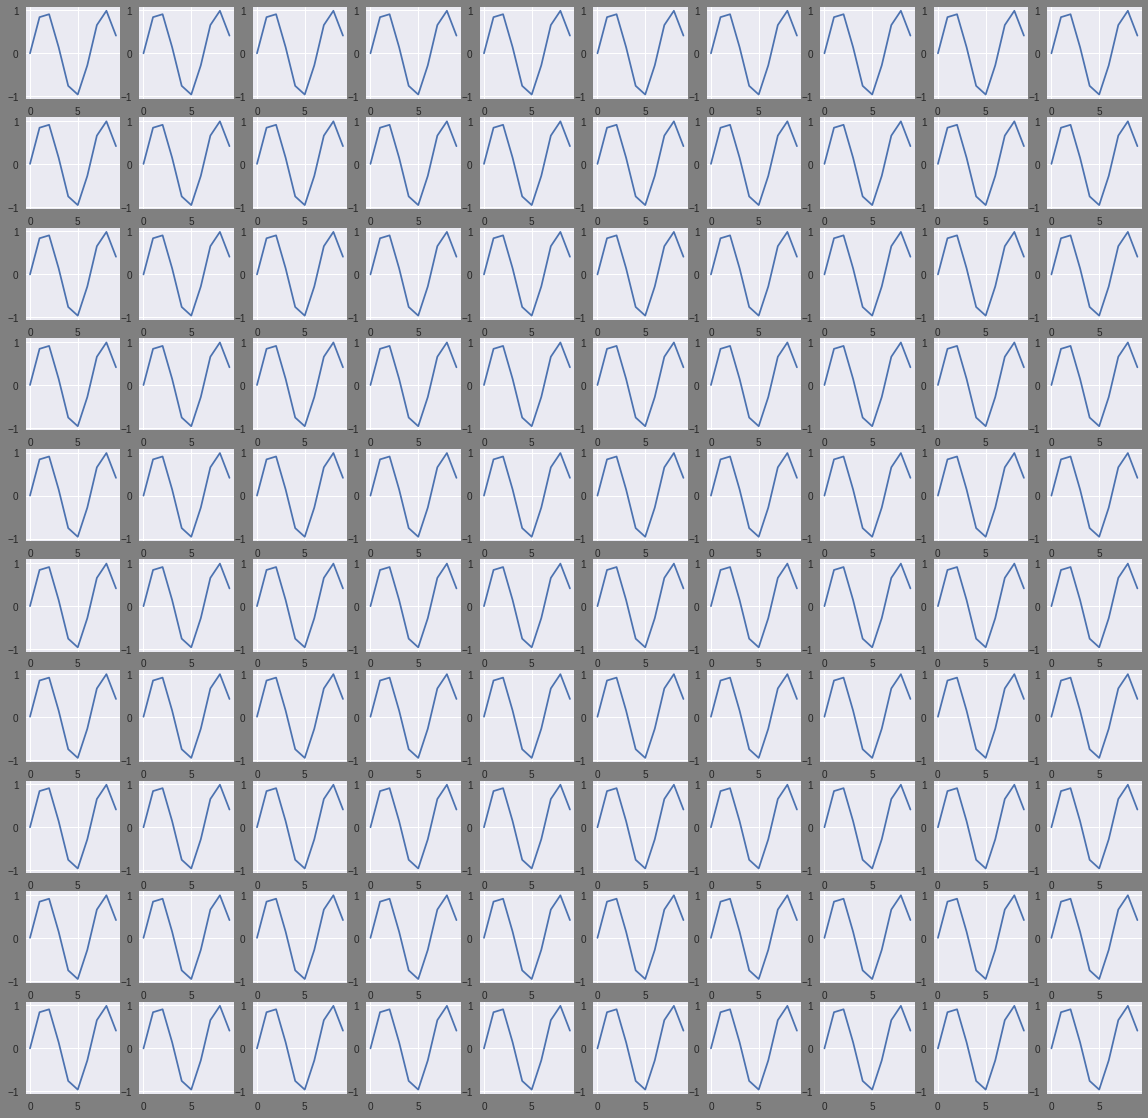

In [0]:
plt.figure(figsize=(20,20), facecolor='grey')
for n in range(10):
  for m in range(10):
    plt.subplot(10, 10, n*10+m+1)
    plt.plot(range(10), np.sin(range(10)))
plt.show()

In [0]:
a = np.array([10, 5, 8, 20])
np.argsort(-a)

array([3, 0, 2, 1])

In [0]:
a = np.arange(10).reshape(10,1)
b = np.argsort(-a.flatten())
b

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [0]:
# a = []
a.append(np.zeros((10, 1)))
np.concatenate(a, axis=1).shape

(10, 3)

In [0]:
a = []
a.append(1)
a

[1]

In [0]:
a = np.random.rand(10)
print(a)
b = np.argsort(a)
print(a)

[0.45825777 0.74156009 0.56748273 0.18033675 0.72925132 0.16875385
 0.73793131 0.00191856 0.00235006 0.24130894]
[0.45825777 0.74156009 0.56748273 0.18033675 0.72925132 0.16875385
 0.73793131 0.00191856 0.00235006 0.24130894]


In [0]:

np.argsort(b)

array([6, 4, 1, 9, 5, 8, 7, 0, 3, 2])